# Predicting fluxes on grid

In [1]:
import sys
import xarray as xr
import numpy as np
from joblib import load
from matplotlib import pyplot as plt
from datacube.utils.dask import start_local_dask

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/dea_tools')
from classification import predict_xr

/home/547/cb3058/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
client = start_local_dask(mem_safety_margin='2Gb')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46819,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://127.0.0.1:44159,Total threads: 16
Dashboard: /proxy/42919/status,Memory: 44.92 GiB
Nanny: tcp://127.0.0.1:40491,


## Open model

In [ ]:
model = load('/g/data/os22/chad_tmp/NEE_modelling/results/models/AUS_NEE_model.joblib').set_params(n_jobs=1)

## Open predictor data

In [ ]:
data0 = xr.open_mfdataset()

## Open variable names and index data into correct order

TO DO: make this programmatic

In [ ]:
f = open("/g/data/os22/chad_tmp/NEE_modelling/results/variables.txt", "r")
variables = f.read()
variables = variables.split(",")
print(variables)

In [ ]:
data = data[['tavg','soil_moisture','rain','lai','vpd','tavg_L1','soil_moisture_L1','rain_L1','lai_L1','vpd_L1']]

### Predict each time-step seperately

- TO DO: fix timesteps that come back from `predict_xr`

In [ ]:
mask = ~np.isnan(data.lai.isel(time=1)).compute()

In [ ]:
results = []
for i in range(1, len(data.time)): #start from 1 as first time-step doesn't have lags
    predicted = predict_xr(model,
                        data.isel(time=i),
                        proba=False,
                        clean=True,
                          ).compute()
    
    predicted = predicted.Predictions.where(mask)
    predicted['time'] = data.isel(time=i).time.values
    results.append(predicted)

In [ ]:
nee = xr.concat(results, dim='time').sortby('time').rename('NEE')

In [ ]:
nee.to_netcdf('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/nee_AUS_2015_2020.nc')

In [3]:
nee = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/nee_AUS_2015_2020.nc')


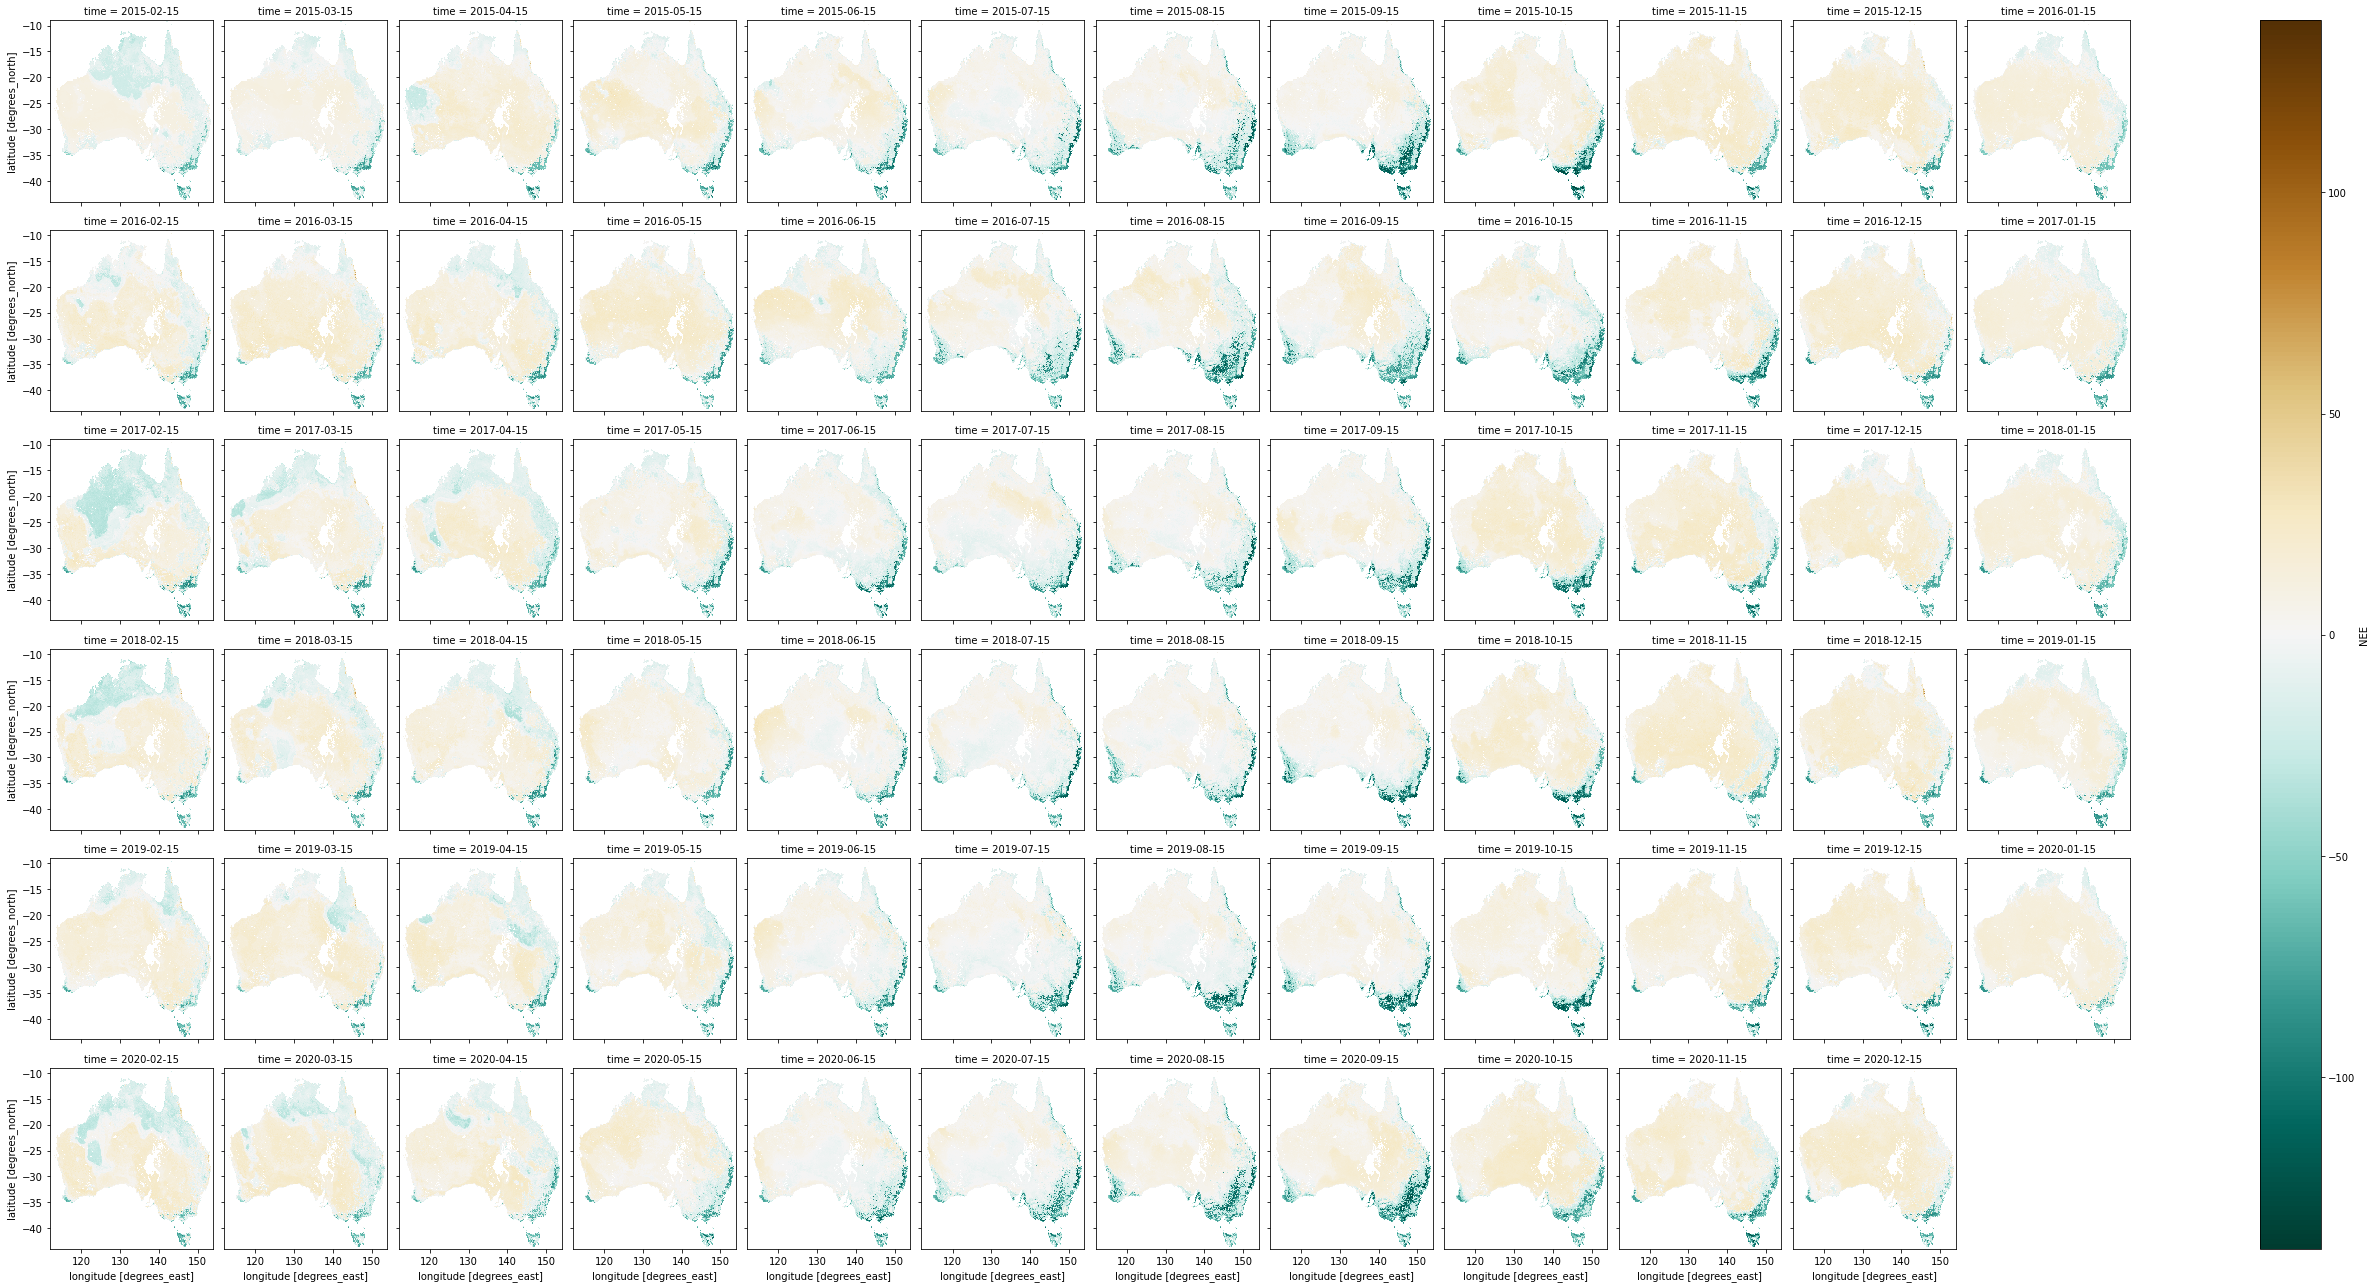

In [4]:
nee.plot.imshow(col='time', col_wrap=12, cmap='BrBG_r') #BrBG
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/NEE_AUS_MODEL_2015_2020.png');

In [ ]:
nee_1D = nee.sum(['x','y'])

In [ ]:
nee_1D.plot(figsize=(12,4), marker='o', linestyle='--')
plt.axhline(y=0.5, color='orange', linestyle='-')
plt.ylim(-nee_1D.max(),nee_1D.max())
plt.title("NEE 'AUS' MODEL");

In [ ]:
nee_1D_annual = nee_1D.resample(time='1Y').sum()
nee_1D_annual.plot(figsize=(12,4), marker='o', linestyle='--')
plt.ylim(-nee_1D_annual.max(), nee_1D_annual.max())
plt.title("NEE 'AUS' MODEL");